# PROJET SD 701 -  Collecte et compilation des données

In [92]:
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from sklearn import cluster

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as axis
import seaborn as sns

from xml.dom import minidom
from lxml import etree
from bs4 import BeautifulSoup
import io
from os import listdir
import json

import datetime
import time
from meteostat import Point, Daily, Hourly
from operator import itemgetter
import random

# I. df_sites:  référencement sites de mesure des polluants
Un fichier xml est fourni avec les données pour la compréhension du dataset. Dans notre cas, il fournit les coordonnées des sites de mesure.

In [100]:
# création de df_sites

root = etree.parse("fr-2020-d-lcsqa-ineris-20210412.xml")
localId, name, coord, alt = [], [], [], []

for i in root.findall(".//{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}AQD_Station"):
    localId.append(i.find(".//{http://inspire.ec.europa.eu/schemas/base/3.3}localId").text)
    name.append(i.find(".//{http://inspire.ec.europa.eu/schemas/ef/3.0}name").text)
    coord.append(list(map(float, i.find(".//{http://www.opengis.net/gml/3.2}pos").text.split())))
    alt.append(float(i.find(".//{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}altitude").text))

# Création du DataFrame des sites de mesures
df_sites = pd.DataFrame({'code site': [x.split("-")[1] for x in localId], 
                         'nom site': name, 
                         'lat': [x[0] for x in coord],
                         'long': [x[1] for x in coord],
                        'alt': alt})

# enregistrement:
output = 'dataset/df_sites_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv'
df_sites.to_csv(output, index = False)

In [102]:
# Charge du dernier df_sites
df_sites = pd.read_csv(['dataset/'+f for f in listdir('dataset') if f.split('_')[1] == 'sites'][-1], 
                       index_col = None)
print("ouverture de %s\n" % ['dataset/'+f for f in listdir('dataset') if f.split('_')[1] == 'sites'][-1])
df_sites.info()

ouverture de dataset/df_sites_20211125_091353.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code site            833 non-null    object 
 1   nom site             833 non-null    object 
 2   lat                  833 non-null    float64
 3   long                 833 non-null    float64
 4   alt                  833 non-null    float64
 5   Altitude Moyenne     833 non-null    float64
 6   Code INSEE           833 non-null    object 
 7   Code Postal          833 non-null    object 
 8   Commune              833 non-null    object 
 9   Département          833 non-null    object 
 10  Région               833 non-null    object 
 11  Statut               833 non-null    object 
 12  Superficie           833 non-null    float64
 13  Population           833 non-null    float64
 14  geo_shape            833 non-null    ob

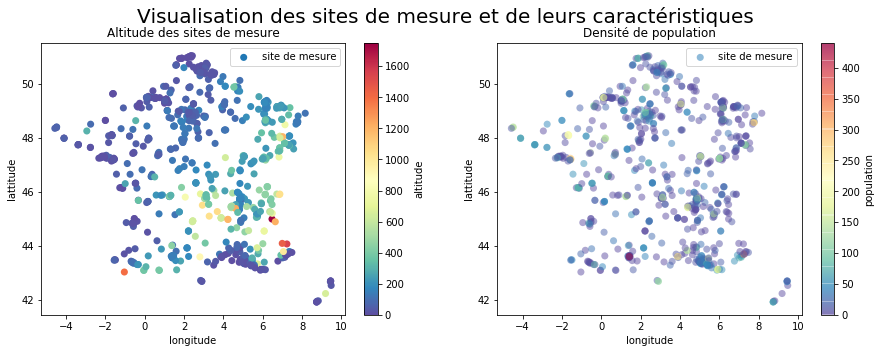

In [103]:
# Cartographie des sites: métropole et DOMTOM
plt.figure(figsize=(15,5))

plt.suptitle('Visualisation des sites de mesure et de leurs caractéristiques', size = 20)

plt.subplot(121)
var1 = plt.scatter(df_sites.loc[df_sites['lat'] > 40, 'long'], df_sites.loc[df_sites['lat'] > 40, 'lat'],
            c=df_sites.loc[df_sites['lat'] > 40, 'alt'],
            cmap=plt.cm.Spectral_r,
            edgecolors='none', s=50,
            label = 'site de mesure')
plt.xlabel('longitude')
plt.ylabel('lattitude')
plt.legend()
plt.colorbar(var1, label='altitude')
plt.title("Altitude des sites de mesure")

plt.subplot(122)
var2 = plt.scatter(df_sites.loc[df_sites['lat'] > 40, 'long'], df_sites.loc[df_sites['lat'] > 40, 'lat'],
            c=df_sites.loc[df_sites['lat'] > 40, 'Population'],
            cmap=plt.cm.Spectral_r,
            edgecolors='none', s=50, alpha = 0.5,
            label = 'site de mesure')
plt.xlabel('longitude')
plt.ylabel('lattitude')
plt.legend()
plt.colorbar(var2, label='population')
plt.title("Densité de population")

plt.show()

# Import des polygones de départements

In [270]:
# import des départements
with open('depreg.geojson') as fic_depreg:
    depreg = json.load(fic_depreg)
df_dep = pd.DataFrame({'num':[i['properties']['code']for i in depreg['features']],
                      'poly_dep': [i['geometry']['coordinates'] for i in depreg['features']]})
df_dep.head()

,num,poly_dep
0,02,"[[[3.172704445659, 50.011996744997], [3.182197..."
1,10,"[[[3.4147888224632, 48.390268550005], [3.42207..."
2,14,"[[[-1.1196198636379, 49.355568981262], [-1.115..."
3,15,"[[[2.5084125130653, 45.478501516921], [2.52443..."
4,28,"[[[0.8148247207739, 48.670163564137], [0.82767..."


In [82]:
# récupération des polygones
def ret_lis(l, w):
    if type(l[0][0]) != float:
        for i in l:
            ret_lis(i, w)
    else:
            w.append(l)
    return w

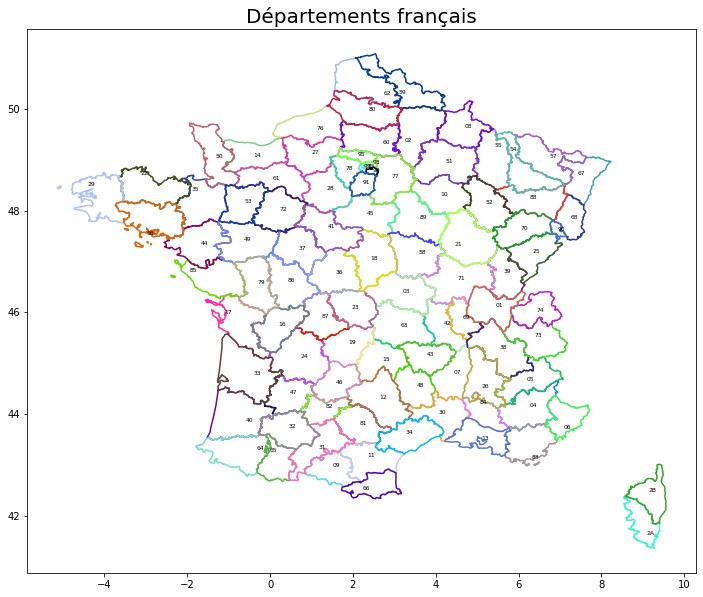

In [124]:
# couleurs aléatoires
color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(len(df_dep))]


# représentation graphique
plt.figure(figsize=(12,10))
compteur = 0
for i in df_dep['poly_dep']:
    w=[]
    polys = ret_lis(i, w)
    pt_moy = [0,0]
    for poly in polys:
        x, y = [j[0] for j in poly], [j[1] for j in poly]
        plt.plot(x, y, c=color[compteur])
        pt_moy[0] = pt_moy[0] + sum(x)/len(x)/len(polys)
        pt_moy[1] = pt_moy[1] + sum(y)/len(y)/len(polys)
    plt.text(pt_moy[0], pt_moy[1], df_dep['num'][compteur], size = 6)
    compteur +=1
plt.title('Départements français', size = 20)
plt.show()

# II. NRJ

On utilise le pic de consommation journalière en France

In [125]:
url1 = 'https://opendata.reseaux-energies.fr/explore/dataset/pic-journalier-consommation-brute/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
df_conso = pd.read_csv(url1, sep=";")
df_conso['Date'] = pd.to_datetime(df_conso['Date'])
df_conso = df_conso[['Date', 'Pic journalier consommation (MW)']]
df_conso = df_conso.rename({'Pic journalier consommation (MW)': 'PicJourConsoNat'}, axis=1)
#df_gaz = pd.read_csv("consommation-maximale-horaire-de-gaz-par-jour-a-la-maille-regional.csv", sep=";")
#df_gaz['Date'] = pd.to_datetime(df_gaz['Date'])
#df_gaz = df_gaz[['Date','Code INSEE Région', 'Consommation Maximale (MWh)']]
#df_gaz = df_gaz.rename({'Consommation Maximale (MWh)': 'ConsoMaxGazReg'}, axis=1)
#df_conso = pd.merge(df_gaz,df_conso,left_on='Date',right_on='Date',how='left')
df_conso.head()

,Date,PicJourConsoNat
0,2021-10-31,49505.0
1,2021-10-30,53483.0
2,2021-10-29,58910.0
3,2021-10-28,61095.0
4,2021-10-27,60513.0


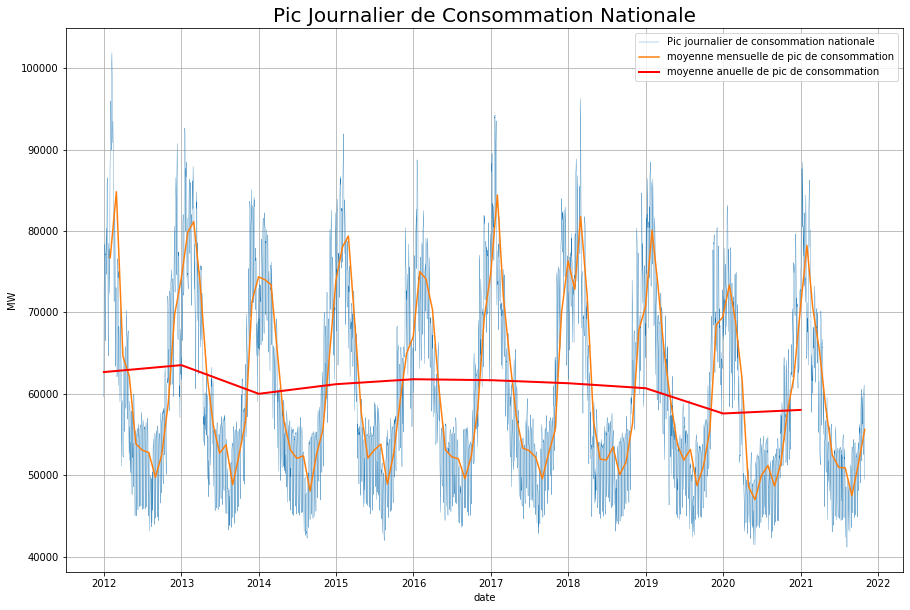

In [161]:

plt.figure(figsize=(15,10))
plt.plot(df_conso['Date'], df_conso['PicJourConsoNat'],
         label = 'Pic journalier de consommation nationale', linewidth=0.3)
df_conso_y = df_conso.set_index('Date').resample('AS').mean()
df_conso_m = df_conso.set_index('Date').resample('M').mean()
plt.plot(df_conso_m.index, df_conso_m['PicJourConsoNat'], label = 'moyenne mensuelle de pic de consommation',
        linewidth = 1.5)
plt.plot(df_conso_y.index, df_conso_y['PicJourConsoNat'], label = 'moyenne anuelle de pic de consommation',
        linewidth = 2, c='r')
plt.legend()
plt.xlabel('date')
plt.ylabel('MW')
plt.grid()
plt.title('Pic Journalier de Consommation Nationale', size = 20)
plt.show()

# II. météo: utilisation de la librairie meteostat
Pour cette phase on va rechercher les mesures disponibles sur data.gouv.fr. Si les données 2021 sont disponibles en fichier CSV, celles des années antérieures sont compilées sous format xml. Un fichier quotidien représente environ une mesure par heure par site et par type de polluant détecté (Ozone, NOX et NO2). On s'intéressera ici uniquement au NOX et NO2. 

https://files.data.gouv.fr/lcsqa/concentrations-de-polluants-atmospheriques-reglementes/old/2019/

Ce type de dataset heure par heure pour près de 530 sites de mesure est très volumineux. Sur dix mois, on obtient plsu de 12 millions de mesures et la concaténation des mesures de pollution avec les mesures météo est très lente (le calcul météo pour une ligne prend environ 0.1s). Le choix se porte alors sur un calcul du cumul de la pollution journalière. 
La fonction Daily de Meteostat permet d'obtenir plusieurs mesures collectées sur un site proche des coordonnées fournies.


In [238]:
Daily(Point(random.uniform(41,51), random.uniform(-5,10) , random.uniform(0, 1000)), 
      datetime.datetime(2021, 1,1), 
      datetime.datetime(2021,1,5)).fetch()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2021-01-02,-5.5,-9.1,-3.2,0.0,NaN,292.0,5.3,NaN,1014.1,NaN
2021-01-03,-4.6,-6.3,-4.0,0.9,NaN,32.2,14.0,NaN,1014.3,NaN
2021-01-04,-4.6,-5.7,-3.8,1.0,NaN,51.8,11.6,NaN,1015.2,NaN
2021-01-05,-4.6,-5.4,-4.0,0.1,NaN,42.1,14.0,NaN,1015.8,NaN


In [239]:
# légende Météostat
pd.read_html('https://dev.meteostat.net/python/daily.html#api',header=0,
                   keep_default_na=False)[0]

,Column,Description,Type
0,station,The Meteostat ID of the weather station (only ...,String
1,time,The date,Datetime64
2,tavg,The average air temperature in °C,Float64
3,tmin,The minimum air temperature in °C,Float64
4,tmax,The maximum air temperature in °C,Float64
5,prcp,The daily precipitation total in mm,Float64
6,snow,The snow depth in mm,Float64
7,wdir,The average wind direction in degrees (°),Float64
8,wspd,The average wind speed in km/h,Float64
9,wpgt,The peak wind gust in km/h,Float64


# III. df_tot : dataset pollution des années précédentes en format xml
On va désormais travailler de début 2018 à mars 2021. Durant cette période, les fichiers de types xml sont déposés sur le site datagouv plusieurs fois par jours sous le même format. Ils intègrent, en plus de l'horaire de mesure et du site de mesure, le type de polluant, le code de validité et le code de vérification comme présentés ci-dessous:

types de polluants:
http://dd.eionet.europa.eu/vocabulary/aq/pollutant/view?page=1#vocabularyConceptResults

In [102]:
print('Code de vérification:')
tbl_verification = pd.DataFrame({'code verification':[1,2,3],'description':['Verified','Preliminary verified','Not verified']})
tbl_verification.set_index('code verification')

Code de vérification:


,description
code verification,
1,Verified
2,Preliminary verified
3,Not verified


In [103]:
print('Code de validité:')
tbl_validite = pd.DataFrame({'code validité':[-99,-1,1,2,3],
                                 'description': ['Not valid due to station maintenance or calibration in the observationvalidity vocabulary',
                                                 'Not valid',
                                                 'Valid',
                                                 'Valid, but below detection limit measurement value given in the observationvalidity vocabulary',
                                                 'Valid, but below detection limit and number replaced by 0.5*detection limit in the observationvalidity vocabulary']})
tbl_validite.set_index('code validité')

Code de validité:


,description
code validité,
-99,Not valid due to station maintenance or calibr...
-1,Not valid
1,Valid
2,"Valid, but below detection limit measurement v..."
3,"Valid, but below detection limit and number re..."


### 41. Création d'un exécutable pour l'import et la compilation totale des données

In [ ]:
# Exécutable de téléchargement et compilation

# télécharger en dur des fichiers et compilation
# commande: python3 d.py <année>
# fichier d.py à placer dans un dossier vierge
# retourne le df enregistré dans df_<année>.csv

from bs4 import BeautifulSoup
import requests
import subprocess
import sys
import pandas as pd
from lxml import etree
from os import listdir
import datetime

# fonction de commande linux
def cmdsh(cmd):
    try:
        output = subprocess.check_output(cmd, shell=True, universal_newlines=True, stderr= subprocess.STDOUT)
    except subprocess.CalledProcessError as exc:
        print("Status : FAIL", exc.returncode, exc.output)
        return False
    else:
        return True

# fonction de parsing de chaque fichier xml téléchargé
def pars(xml):
    root = etree.parse(xml)
    site=[]
    poll = []
    
    
    verif=[]
    valid=[]
    mesure=[]
    for i in root.findall('.//{http://www.opengis.net/gml/3.2}featureMember')[1:]:
        if i.find('.//{http://www.opengis.net/swe/2.0}values') != None:
            if i.find('.//{http://www.opengis.net/swe/2.0}values').text != None:
                valeurs = i.find('.//{http://www.opengis.net/swe/2.0}values').text.split('@@')[:-1]
                verif += [k.split(",")[2] for k in valeurs]
                valid += [k.split(",")[3] for k in valeurs]
                mesure += [k.split(",")[4] for k in valeurs]
                a = i.find('.//{http://www.opengis.net/om/2.0}featureOfInterest').attrib.get('{http://www.w3.org/1999/xlink}href').split("-")[-1].split("_")
                site += [a[0] for _ in range(len(valeurs))]
                poll += [a[1] for _ in range(len(valeurs))]
    
    w = pd.DataFrame({'code site':site, 
                      'poll': poll, 
                      'GDH': datetime.datetime(int(xml[-19:-15]),
                                               int(xml[-14:-12]), 
                                               int(xml[-11:-9])), 
                       'verif': verif, 'valid':valid, 'valeur': mesure})
    w['GDH'] = pd.to_datetime(w['GDH'])
    w['valeur'] = pd.to_numeric(w['valeur'])

    
    return w.groupby(['code site', 
                      'poll', 
                      'GDH', 
                      'verif', 
                      'valid']).valeur.agg(['mean', 
                                            'max', 
                                            'min']).reset_index()


# fonction principale
def main():
    an = sys.argv[1]
    
    # récupération de la liste des xml à télécharger
    url0 = 'https://files.data.gouv.fr/lcsqa/concentrations-de-polluants-atmospheriques-reglementes/old/'+an+'/'
    soup = BeautifulSoup(requests.get(url0).content, features="lxml") 
    fichiers = []
    print('récupération des noms de fichiers téléchargeables')
    for div in soup.findAll('a'):
        fichiers.append(url0+div.text)
    
    # téléchargement des xml placés dans le dossier xml-<années>/
    path='xml-'+an+'/'
    print('création du répertoire '+path)
    try:
        cmdsh('mkdir '+path)
    except:
        print('dossier '+path+' déja existant')
    
    dej = [l for l in listdir(path)]
    tel = [f for f in fichiers[1:] if f.split("/")[-1] not in dej]
    
    compteur=1
    if tel != []:
        print('téléchargement des fichiers')
        for f in tel:
            print(f'progression: {compteur*100//len(fichiers)}%\r', end='')
            cmdsh('wget -nv -P ~/SD701/xml-'+an+'/ '+f)
            compteur += 1
        print()
    
    catalogue = []
    print('récupération de la liste des xml téléchargés')
    fic = [f for f in listdir(path) if f.split(".")[-1] == 'xml']
    
    # parsing en deux étapes
    
    compteur = 0
    print('début du parsing')
    p = len(fic)//2
    part1 = 'df_part1-'+an+'.csv'
    if part1 in listdir('.'):
        print('part1 déjà effectuée')
    else:
        print('part1')
        for f in [a for a in fic[:p] if a[8:10] == 'e2']:
            catalogue.append(pars(path+f))
            print(f'progression: {compteur*100//len(fic)}%\r', end='')
            compteur += 1
        print()
        # concaténation partielle
        print('concaténation partielle 1')
        df_part1 = pd.concat(catalogue).groupby(['code site', 
                      'poll', 
                      'GDH', 
                      'verif', 
                      'valid'])['mean', 'max', 'min'].agg('mean').reset_index()
        df_part1.to_csv(part1)
    

    
    part2 = 'df_part2-'+an+'.csv'
    if part2 in listdir('.'):
        print('part2 déjà effectuée')
    else:
        print('part2')
        catalogue=[]
        for f in [a for a in fic[p:] if a[8:10] == 'e2']:
            catalogue.append(pars(path+f))
            print(f'progression: {compteur*100//len(fic)}%\r', end='')
            compteur += 1
        # concaténation partielle
        print('concaténation partielle 2')
        df_part2 = pd.concat(catalogue).groupby(['code site', 
                      'poll', 
                      'GDH', 
                      'verif', 
                      'valid'])['mean', 'max', 'min'].agg('mean').reset_index()
        df_part2.to_csv(part2)
        catalogue=[]
    print()
    

    
    # concaténation finale
    print('concaténation finale')
    # vidage mémoire et rechargement des df partiels (si saut d'étape)
    part1=''
    part2=''
    df_tot = pd.concat([pd.read_csv('df_part1-'+an+'.csv', index_col=None),
                      pd.read_csv('df_part2-'+an+'.csv', index_col=None)],
                      ignore_index = True)
    
    # enregistrement du df complet
    print('enregistrement du df total')
    df_tot.to_csv('df_'+an+'.csv')
    cmdsh('rm -rf df_part*')
    
              
if __name__ == '__main__':
    main()

### 42. Création df_tot et compilation avec les autres données

In [168]:
df_sites.columns

Index(['code site', 'nom site', 'lat', 'long', 'alt', 'Altitude Moyenne',
       'Code INSEE', 'Code Postal', 'Commune', 'Département', 'Région',
       'Statut', 'Superficie', 'Population', 'geo_shape', 'poly_dep',
       'Code Commune', 'Code Canton', 'Code Arrondissement',
       'Code Département', 'Code Région'],
      dtype='object')

In [274]:
def compil():
    # compilation des df de toutes les années et enregistrement d'un df complet
    tp = time.time()
    print('-------COMPILATION DATASET ANNUELS de POLL + DF_SITES + MTO + PIC DE CONSO EN FRANCE --------')
    df_list = [pd.read_csv('dataset/df_20'+str(i)+'.csv', index_col=None) for i in range(18,22)]
    df_tot = pd.concat(df_list)
    print('\tdataset annuels compilés - %.fs' % (time.time()-tp))
    tps = time.time()
    df_tot.drop(df_tot.columns[[0,1]], axis = 1, inplace=True)
    df_tot.drop(df_tot.loc[df_tot['valid']==-1].index, axis = 0, inplace = True)
    df_tot['GDH'] = pd.to_datetime(df_tot['GDH'])

    # fusion avec df_site:
    print('fusion avec df_sites')
    df_sites_restreint = df_sites[['code site', 'lat', 'long', 'alt', 'Population', 'Code Département']]
    df_tot = pd.merge(df_tot,df_sites_restreint, left_on='code site',right_on='code site',how='left')
    # restriction des sites à la métropole
    df_tot = df_tot.loc[df_tot['lat']>40]
    print('\tdf_site compilé - %.fs' % (time.time()-tps))
    tps = time.time()

    # fusion avec données MTO
    print('fusion avec données MTO')
    dataset = []
    compteur = 1
    sites = set(df_tot['code site'])
    
    for i in sites:
        print(f'\tprogression: {(100*compteur)//len(sites)}%\r', end='')
        a = df_tot.groupby('code site').get_group(i)
        start = list(a['GDH'])[0]
        end = list(a['GDH'])[-1]
        newindex = pd.date_range(start=start, end=end, freq='D')
        b = Daily(Point(a['lat'].iloc[0],a['long'].iloc[0] ,192), start, end).fetch()
        dataset.append(pd.merge(a,b,left_on='GDH',right_on=b.index,how='left'))
        compteur += 1
    df_tot = pd.concat(dataset)
    df_tot.reset_index(inplace = True)
    print('\tdonnées mto compilées - %.fs' % (time.time()-tps))
    tps = time.time()
    
    # fusion avec pic de conso journalière (PCJ) en MW:
    print('compilation avec les données énergétiques')
    df_tot = pd.merge(df_tot,df_conso,left_on='GDH',right_on='Date',how='left')
    print('\tdonnées énergétiques compilées - %.fs' % (time.time()-tps))
    tps = time.time()
    
    # ajout submetric de jour de la semaine (cos(No x 2pi/7), sin(No x 2pi/7))
    df_tot['Jx'] = df_tot['GDH'].dt.dayofweek.apply(lambda x: m.cos(x*2*m.pi/7))
    df_tot['Jy'] = df_tot['GDH'].dt.dayofweek.apply(lambda x: m.sin(x*2*m.pi/7))
    
    # nettoyage final
    print('nettoyage final')
    df_tot.drop('Date', axis = 1, inplace = True)
    df_tot.rename({'mean':'mesure', 'poll': 'type_poll', 'max': 'mesure_max', 'min': 'mesure_min'}, 
                  axis = 1, inplace = True)
    df_tot = df_tot.loc[df_tot['mesure'] < 200]
    df_tot = df_tot[['GDH', 'code site',
                     'PicJourConsoNat',
                     'type_poll','verif', 'valid', 'mesure', 'mesure_max', 'mesure_min',
                     'lat', 'long', 'alt', 'Population', 'Code Département',
                     'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun',
                     'Jx', 'Jy'
                    ]]
    print('\tnettoyage final réalisé')
    
    # sauvegarde
    print('sauvegarde de df_tot')
    output = 'dataset/df_tot_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv'
    df_tot.to_csv(output)
    print('\tsauvegardé dans ' + output)
    print(f'-------OPERATION TERMINEE -- TEMPS TOTAL {(time.time() - tp)}s --------')
    return df_tot.head()

df_tot = compil()

-------COMPILATION DATASET ANNUELS de POLL + DF_SITES + MTO + PIC DE CONSO EN FRANCE --------
	dataset annuels compilés - 6s
fusion avec df_sites
	df_site compilé - 9s
fusion avec données MTO
	données mto compilées - 276s
compilation avec les données énergétiques
	données énergétiques compilées - 1s
nettoyage final
	nettoyage final réalisé
sauvegarde de df_tot
	sauvegardé dans dataset/df_tot_20211125_210212.csv
-------OPERATION TERMINEE -- TEMPS TOTAL 382.6774389743805s --------


In [275]:
# ouverture du dernier df_tot

fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1]=='tot'], 
                                    key=itemgetter(2,3))[-1])
print('ouverture de %s\n' % fic )
df_tot = pd.read_csv(fic)
df_tot.drop(df_tot.columns[0], axis = 1, inplace = True)
df_tot['GDH'] = pd.to_datetime(df_tot['GDH'])
df_tot.info()

ouverture de dataset/df_tot_20211125_210212.csv



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222656 entries, 0 to 2222655
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   GDH               datetime64[ns]
 1   code site         object        
 2   PicJourConsoNat   float64       
 3   type_poll         int64         
 4   verif             int64         
 5   valid             int64         
 6   mesure            float64       
 7   mesure_max        float64       
 8   mesure_min        float64       
 9   lat               float64       
 10  long              float64       
 11  alt               float64       
 12  Population        float64       
 13  Code Département  object        
 14  tavg              float64       
 15  tmin              float64       
 16  tmax              float64       
 17  prcp              float64       
 18  snow              float64       
 19  wdir              float64       
 20  wspd              float64       
 21  wpgt    

In [276]:
df_tot

,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Jx,Jy
0,2018-09-17,FR02011,53588.0,1,3,1,0.183333,0.500000,0.000000,43.43786,...,25.9,0.0,NaN,84.3,5.8,27.8,1019.8,NaN,1.000000,0.000000
1,2018-09-20,FR02011,54243.0,1,3,1,1.050000,2.000000,0.500000,43.43786,...,29.9,0.0,NaN,40.2,6.1,35.2,1017.5,NaN,-0.900969,0.433884
2,2018-09-22,FR02011,47614.0,1,3,1,3.530000,29.800000,-0.300000,43.43786,...,27.9,0.0,NaN,323.1,18.5,55.5,1019.0,NaN,-0.222521,-0.974928
3,2018-09-24,FR02011,53454.0,1,2,1,19.148053,105.650000,0.250000,43.43786,...,23.9,0.0,NaN,323.0,33.2,81.5,1019.4,NaN,1.000000,0.000000
4,2018-09-27,FR02011,54560.0,1,3,1,1.283689,3.428571,0.000000,43.43786,...,23.5,0.0,NaN,329.3,9.9,22.2,1028.9,NaN,-0.900969,0.433884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222651,2021-03-02,FR03071,67536.0,8,2,1,36.770833,72.600000,16.800000,43.13111,...,14.2,0.0,NaN,80.2,20.3,35.2,1031.3,NaN,0.623490,0.781831
2222652,2021-03-03,FR03071,65661.0,8,2,1,23.041748,72.600000,3.500000,43.13111,...,13.6,0.0,NaN,69.1,9.4,25.9,1031.2,NaN,-0.222521,0.974928
2222653,2021-03-03,FR03071,65661.0,8,3,1,42.903459,72.910000,17.500000,43.13111,...,13.6,0.0,NaN,69.1,9.4,25.9,1031.2,NaN,-0.222521,0.974928
2222654,2021-03-06,FR03071,63233.0,8,3,1,16.701811,42.058333,7.800000,43.13111,...,13.6,0.6,NaN,72.1,20.1,37.0,1022.8,NaN,-0.222521,-0.974928


In [246]:
df_tot['type_poll'].value_counts()

8       642050
5       575214
7       501420
6001    260003
1       163024
38       24248
9        23509
10       22481
20       10825
Name: type_poll, dtype: int64

In [254]:
a = df_tot.groupby(['code site', 'type_poll']).agg({'lat': 'mean'})

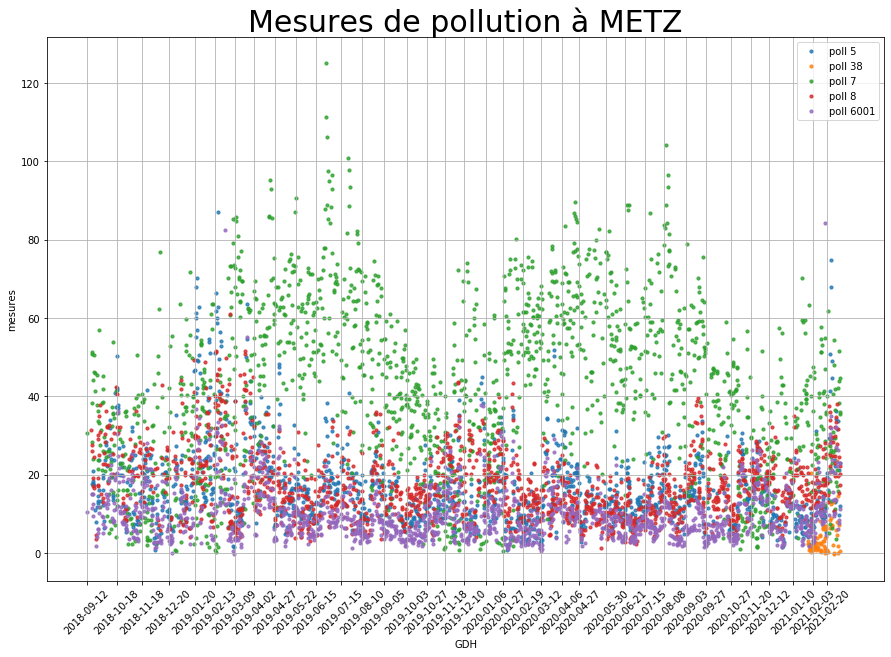

In [265]:
##### affichage de la pollution sur un site


a = df_tot.groupby('code site').get_group('FR01011')
a = a.sort_values('GDH')

plt.figure(figsize=(15,10))
for i in set(a['type_poll']):
    b = a.groupby('type_poll').get_group(i).sort_values('GDH')
    plt.scatter(b['GDH'], b['mesure'], label = 'poll '+ str(i), s=10, alpha = 0.8)
plt.legend()
plt.xlabel('GDH')
plt.xticks(a.GDH[::180], rotation = 45)
plt.ylabel('mesures')
plt.title('Mesures de pollution à METZ', size=30)
plt.grid()
plt.show()

# Annexe  df_2021: travail sur des csv
La compilation se fait directement lors de la récupération par URL des données journalières. Le calcul est long car pour chaque observation on fait appel à une fonction permettant de calculer une valeur moyenne de la température journalière en fonction des mesures enregistrées sur les sites de relevé les plus proches dans la période d'intérêt. 
Le temps de calcul avoisinne 40 minutes pour 150 000 lignes collectées.
Le dataset est chargé par script python sur les machines de l'école. Le code est placé ci-dessous mais ne doit pas être lancé (la cellule est passé en Markdown pour s'en assurer)

In [101]:
def compil_2021():
    # import des données pollution
    start = time.time()
    url0='https://files.data.gouv.fr/lcsqa/concentrations-de-polluants-atmospheriques-reglementes/temps-reel/2021/'
    soup = BeautifulSoup(requests.get(url0).content) 
    fichiers = []
    for div in soup.findAll('a'):
        if div.text[-1]=='v':
            fichiers.append(url0+div.text)
    dataset = []

    print('téléchargement des fichiers de pollution: ')
    compteur = 1
    for i in fichiers:
        print(f'progression: {(100*compteur)//len(fichiers)}%\r', end = '')
        dfj = pd.read_csv(io.StringIO(requests.get(i).content.decode('utf-8')), sep = ";")
        dfj = dfj[['code site', 'valeur']].groupby('code site').mean()
        dfj['code site']=dfj.index
        dfj['GDH']=datetime.datetime(2021,int(i[-9:-7]), int(i[-6:-4]))
        dataset.append(dfj)
        compteur+=1
    print()
    df = pd.concat(dataset)
    df.index = range(len(df))

    # fusion avec df_sites
    df = pd.merge(df,df_sites[['code site', 'Commune', 'lat', 'long', 'alt']],
                  left_on='code site',right_on='code site',how='left')
    df = df [['GDH', 'code site', 'Commune', 'lat', 'long', 'alt', 'valeur']]

    # import des données météo
    df.set_index('GDH', inplace = True)
    newindex = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    compteur = 1
    sites = set(df['code site'])
    dataset = []
    print('\nimport données météo:')
    for i in sites:
        print(f'progression: {(100*compteur)//len(sites)}%\r', end='')
        a = df.groupby('code site').get_group(i).reindex(newindex)
        b = Daily(Point(a['lat'].iloc[0],a['long'].iloc[0] ,192), a.index[0], a.index[-1]).fetch().reindex(newindex)
        dataset.append(pd.merge(a,b,left_on=a.index,right_on=b.index,how='left'))
        compteur += 1
    print()
    df = pd.concat(dataset)
    df.index = range(len(df))
    df = df.rename({'key_0': 'GDH', 'code site' : 'ID_SITE', 'valeur' : 'NOX'}, axis=1)
    df['GDH']=pd.to_datetime(df['GDH'])

    # sauvegarde
    output = 'dataset/df_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv'
    print('\nsauvegarde dans ./' + output)
    df.to_csv(output)
    print("\ntemps de l'opération: %3.f secondes" % (time.time()-start))
    return df.head()

#compil_2021()

téléchargement des fichiers de pollution: 




import données météo:


progression: 100%

sauvegarde dans ./dataset/df_20211117_195429.csv

temps de l'opération: 474 secondes


,GDH,ID_SITE,Commune,lat,long,alt,NOX,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-01-01,FR41003,AFA,41.964443,8.820278,30.0,12.302500,7.2,5.7,9.1,5.8,NaN,61.7,10.0,25.9,1007.0,NaN
1,2021-01-02,FR41003,AFA,41.964443,8.820278,30.0,12.854167,8.7,6.8,11.1,15.2,NaN,130.5,12.1,31.5,1001.2,NaN
2,2021-01-03,FR41003,AFA,41.964443,8.820278,30.0,10.795833,5.8,4.3,9.8,8.9,NaN,41.1,9.5,37.0,1008.3,NaN
3,2021-01-04,FR41003,AFA,41.964443,8.820278,30.0,11.834167,5.4,3.5,11.3,8.4,NaN,36.2,9.4,29.6,1009.8,NaN
4,2021-01-05,FR41003,AFA,41.964443,8.820278,30.0,11.574167,4.5,1.9,7.0,7.9,NaN,36.3,7.8,16.7,1008.6,NaN


In [17]:
# charge de la dernière sauvegarde si besoin
dernier_fic = "dataset/"+[l for l in listdir('dataset')][-1]
df = pd.read_csv(dernier_fic,index_col=0)

In [18]:
# possibilité de rajouter des submetrics: jours de la semaine:
df['GDH']=pd.to_datetime(df['GDH'])
for i in range(7):
    df['day'+str(i)] = (df['GDH'].dt.dayofweek == i)*1
df

,GDH,ID_SITE,Commune,lat,long,alt,NOX,tavg,tmin,tmax,...,wpgt,pres,tsun,day0,day1,day2,day3,day4,day5,day6
0,2021-01-01,FR19014,BREST,48.397460,-4.488710,59.0,25.756944,2.3,-0.2,6.9,...,25.9,1012.0,NaN,0,0,0,0,1,0,0
1,2021-01-02,FR19014,BREST,48.397460,-4.488710,59.0,16.347222,4.2,1.3,7.5,...,27.8,1017.7,NaN,0,0,0,0,0,1,0
2,2021-01-03,FR19014,BREST,48.397460,-4.488710,59.0,12.226389,2.3,0.1,4.3,...,37.0,1015.1,NaN,0,0,0,0,0,0,1
3,2021-01-04,FR19014,BREST,48.397460,-4.488710,59.0,20.263889,2.8,-0.1,5.8,...,33.3,1015.8,NaN,1,0,0,0,0,0,0
4,2021-01-05,FR19014,BREST,48.397460,-4.488710,59.0,20.908333,2.8,2.2,3.5,...,29.6,1017.8,NaN,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174169,2021-11-11,FR21017,OUISTREHAM,49.289444,-0.257778,6.0,30.445833,7.5,2.2,13.2,...,16.7,1023.4,NaN,0,0,0,1,0,0,0
174170,2021-11-12,FR21017,OUISTREHAM,49.289444,-0.257778,6.0,36.479167,8.2,3.2,11.2,...,35.2,1016.5,NaN,0,0,0,0,1,0,0
174171,2021-11-13,FR21017,OUISTREHAM,49.289444,-0.257778,6.0,59.900000,11.0,10.2,12.2,...,33.3,1016.9,NaN,0,0,0,0,0,1,0
174172,2021-11-14,FR21017,OUISTREHAM,49.289444,-0.257778,6.0,50.766667,11.1,10.2,12.2,...,27.8,1020.9,NaN,0,0,0,0,0,0,1


In [328]:
# Plusieurs sites affichent des mesures négatives de pollution, ce qui pose problème pour un passage en log
df.loc[df['NOX']<0, 'ID_SITE'].nunique()

16

In [329]:
# standardisation de tous les paramètres numériques (sauf géographiques):
for i in ['NOX','tavg','tmin','tmax','prcp','snow','wdir','wspd','wpgt','pres','tsun']:
    a = StandardScaler().fit_transform(np.array(df[i]).reshape(-1,1))
    df[i] = a

In [33]:
# Représentation du dataset par jour, aggrégation par mois
df_piv = df.pivot_table(values='NOX', index='GDH', columns='ID_SITE', aggfunc='mean')
df_piv.index = pd.to_datetime(df_piv.index)
df_pivm = df_piv.resample('MS').mean()
df_pivm

ID_SITE,FR01011,FR01012,FR01014,FR01015,FR01016,FR01018,FR01019,FR01020,FR01021,FR01059,...,FR82012,FR82020,FR82030,FR82040,FR82041,FR82042,FR82043,FR82050,FR82060,FR82070
GDH,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.667279,12.438126,11.817742,NaN,9.805813,16.641112,12.788572,17.657814,37.460046,10.658223,...,38.655704,22.482477,27.559002,17.403068,5.933623,8.620066,7.524415,21.200545,26.018024,13.138692
2021-02-01,20.619522,14.414433,21.427442,NaN,13.069675,18.302716,19.220041,24.479528,38.669817,18.297173,...,39.985268,32.893664,39.622353,22.775102,7.705677,7.966966,10.988369,28.800782,33.104317,20.894051
2021-03-01,21.002510,14.545301,16.367904,NaN,14.506981,19.061223,14.417285,23.053033,49.438487,16.022984,...,55.834959,23.136808,22.768730,22.679306,7.922497,8.745911,8.096825,30.364382,35.614651,16.322931
2021-04-01,20.363557,11.105746,14.454167,NaN,11.638688,13.516951,9.923694,23.380430,62.268634,13.195016,...,70.023219,16.824439,34.653247,23.348717,4.935578,6.153622,6.184687,33.393880,41.775564,12.296411
2021-05-01,15.750238,6.081716,7.646348,9.689815,5.507685,16.328518,6.252854,16.522926,61.783495,8.028497,...,66.472312,9.973069,30.551815,19.091713,3.141787,4.376733,4.740320,29.359112,39.293644,7.122064
2021-06-01,18.301590,8.543519,11.738992,16.557083,7.461912,17.481271,7.967606,17.251912,67.217038,16.286111,...,66.088370,15.040552,35.104606,19.699153,2.658153,3.958904,8.272119,30.811209,38.860278,8.477955
2021-07-01,15.128531,7.173227,9.344418,15.056989,7.346118,13.658060,7.692173,14.383281,49.760308,15.003730,...,59.285447,11.809362,29.502840,16.617111,2.381925,4.358099,6.717673,25.947681,32.346182,8.018547
2021-08-01,14.346293,7.017944,7.387715,14.092742,7.637983,16.635389,6.100136,16.241275,52.510741,11.794220,...,49.861290,11.718818,27.541359,15.718802,2.577944,4.303913,5.248174,23.121039,29.870829,7.442516
2021-09-01,18.469909,12.417327,10.947744,16.264167,15.557368,21.071342,10.680273,20.318315,63.497317,14.835139,...,55.290177,19.560010,28.668583,18.289865,3.715539,5.887168,5.615867,25.084913,35.210889,9.933980
